# Burrau example (Github)

## Loading packages

In [1]:
using IRKGaussLegendre
using Plots, LinearAlgebra, LaTeXStrings


## Step 1: Defining the Problem
To solve this numerically, we define a problem type by giving it the equation, the initial condition, and the timespan to solve over:

In [2]:
function NbodyODE!(du,u,Gm,t)
     N = length(Gm)
     du[1,:,:] .= 0
     for i in 1:N
        qi = u[2,:,i]
        Gmi = Gm[i]
        du[2,:,i] = u[1,:,i]
        for j in (i+1):N
           qj = u[2,:,j]
           Gmj = Gm[j]
           qij = qi - qj
           auxij = (qij[1]*qij[1]+qij[2]*qij[2]+qij[3]*qij[3])^(-3/2)
           du[1,:,i] -= Gmj*auxij*qij
           du[1,:,j] += Gmi*auxij*qij
        end
     end

    return
end

NbodyODE! (generic function with 1 method)

In [3]:
Gm = [5, 4, 3]
N=length(Gm)
q=[1,-1,0,-2,-1,0,1,3,0]
v=zeros(size(q))
q0 = reshape(q,3,:)
v0 = reshape(v,3,:)
u0 = Array{Float64}(undef,2,3,N)
u0[1,:,:] = v0
u0[2,:,:] = q0
tspan = (0.0,63.0)
prob=ODEProblem(NbodyODE!,u0,tspan,Gm);

## Step 2: Solving the problem
After defining a problem, you solve it using solve

In [4]:
sol1=solve(prob,IRKGL16(),adaptive=true, reltol=1e-12, abstol=1e-12);

### Orbits

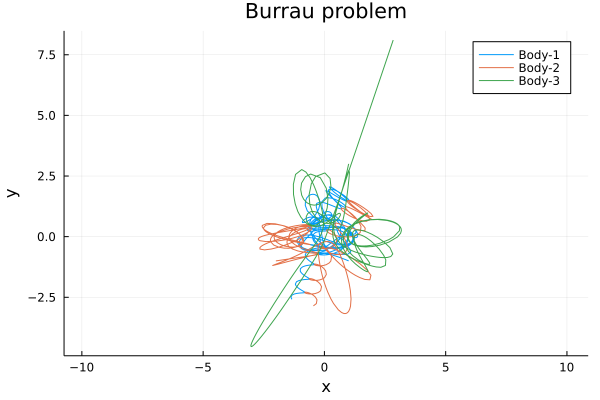

In [5]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl = plot(title="Burrau problem",xlabel="x", ylabel="y",aspect_ratio=1)

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist1)
 ylist  = map(u->u[2,2,j], ulist1)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end  
plot(pl)

### Step size

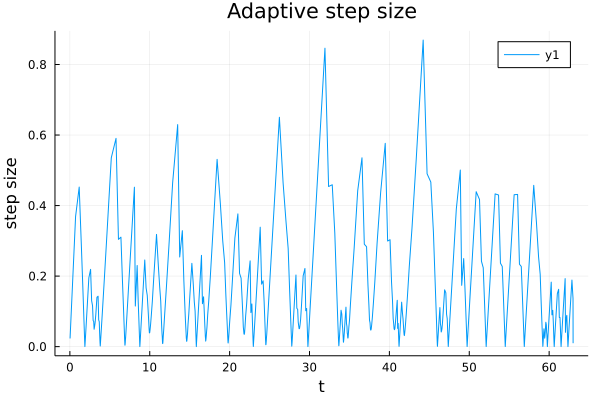

In [6]:
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
plot!(sol1.t[2:end],steps1)

### Energy-Error

In [7]:
function NbodyEnergy(u,Gm)
     N = length(Gm)
     zerouel = zero(eltype(u))
     T = zerouel
     U = zerouel
     for i in 1:N
        qi = u[2,:,i]
        vi = u[1,:,i]
        Gmi = Gm[i]
        T += Gmi*(vi[1]*vi[1]+vi[2]*vi[2]+vi[3]*vi[3])
        for j in (i+1):N
           qj = u[2,:,j]  
           Gmj = Gm[j]
           qij = qi - qj
           U -= Gmi*Gmj/norm(qij)
        end
     end
    1/2*T + U
end

NbodyEnergy (generic function with 1 method)

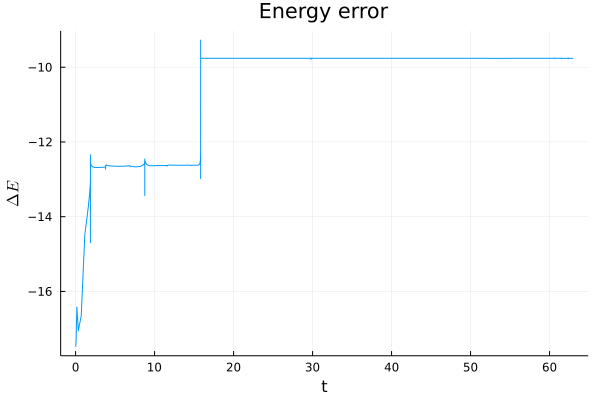

In [8]:
setprecision(BigFloat, 256)
u0Big=BigFloat.(u0)
GmBig=BigFloat.(Gm)

E0=NbodyEnergy(u0Big,GmBig)
ΔE1 = map(x->NbodyEnergy(BigFloat.(x),GmBig), sol1.u)./E0.-1
plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
plot!(sol1.t,log10.(abs.(ΔE1)), label="")